In [22]:
# # check GPU
!nvidia-smi

Fri Jan 13 16:25:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    32W /  70W |   1020MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [23]:
# # pulls repo to colab
!git clone https://github.com/char-tan/mode_connectivity.git

# # checkout specific branch if needed
!cd mode_connectivity; git checkout super_model

fatal: destination path 'mode_connectivity' already exists and is not an empty directory.
M	geodesic_opt.py
Already on 'super_model'
Your branch is up to date with 'origin/super_model'.


In [24]:
# allows you to change the .py files and have the imports updated
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
import sys, os
SCRIPT_DIR = os.path.dirname(os.path.abspath('.'))
sys.path.append(os.path.dirname(SCRIPT_DIR))

sys.path.append("mode_connectivity")

In [26]:
import torch
from torchvision import transforms, datasets
import copy
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

from mode_connectivity.utils import weight_matching, data, training_utils, plot, utils
from mode_connectivity.training_config import *
from mode_connectivity.lmc import *
from mode_connectivity.training import *

from mode_connectivity.models.mlp import MLP

In [27]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


# Training MLP models

In [28]:
training_config = MLP_MNIST_DEFAULT
training_config.epochs = 5
training_config.seed = 7

# train model a
# model_a_noisy = train_model(*setup_train(training_config, additional_train_transforms = [AddGaussianNoise(0., 0.1)]), verbose = 1)
model_a = train_model(*setup_train(training_config), verbose = 1)
torch.save(model_a.state_dict(), 'mlp_mnist_model_a.pt')

# change seed to get different model
training_config.seed = 42

# train model b
# model_b_noisy = train_model(*setup_train(training_config, additional_train_transforms = [AddGaussianNoise(0., 0.1)]), verbose = 1)
model_b = train_model(*setup_train(training_config), verbose = 1)
torch.save(model_b.state_dict(), 'mlp_mnist_model_b.pt')  

Train Epoch: 1, Train Accuracy: (90%) 
Average loss: 0.1301, Accuracy: (96%)
Train Epoch: 2, Train Accuracy: (97%) 
Average loss: 0.0942, Accuracy: (97%)
Train Epoch: 3, Train Accuracy: (98%) 
Average loss: 0.0708, Accuracy: (98%)
Train Epoch: 4, Train Accuracy: (99%) 
Average loss: 0.0864, Accuracy: (97%)
Train Epoch: 5, Train Accuracy: (99%) 
Average loss: 0.0811, Accuracy: (97%)
Train Epoch: 1, Train Accuracy: (90%) 
Average loss: 0.1392, Accuracy: (96%)
Train Epoch: 2, Train Accuracy: (97%) 
Average loss: 0.0911, Accuracy: (97%)
Train Epoch: 3, Train Accuracy: (98%) 
Average loss: 0.0784, Accuracy: (98%)
Train Epoch: 4, Train Accuracy: (98%) 
Average loss: 0.0707, Accuracy: (98%)
Train Epoch: 5, Train Accuracy: (99%) 
Average loss: 0.0840, Accuracy: (98%)


# LMC in param space

In [29]:
n_points = 5
(
    permuted_params,
    train_acc_naive,
    test_acc_naive,
    train_acc_perm,
    test_acc_perm,
) = linear_mode_connect(
    MLP, "mlp_mnist_model_a.pt", "mlp_mnist_model_b.pt", "mnist", n_points=n_points, verbose=1
)
torch.save(permuted_params, 'mlp_mnist_model_pb.pt') 


performing naive interpolation
Average loss: 0.0334, Accuracy: (99%)
Average loss: 0.0811, Accuracy: (97%)
Average loss: 0.2660, Accuracy: (98%)
Average loss: 0.2797, Accuracy: (97%)
Average loss: 1.3403, Accuracy: (91%)
Average loss: 1.3384, Accuracy: (90%)
Average loss: 0.2538, Accuracy: (98%)
Average loss: 0.2732, Accuracy: (97%)
Average loss: 0.0343, Accuracy: (99%)
Average loss: 0.0840, Accuracy: (98%)
point 5/5. 
permuting model

performing permuted interpolation
Average loss: 0.0334, Accuracy: (99%)
Average loss: 0.0811, Accuracy: (97%)
Average loss: 0.0390, Accuracy: (99%)
Average loss: 0.0728, Accuracy: (98%)
Average loss: 0.0466, Accuracy: (99%)
Average loss: 0.0755, Accuracy: (98%)
Average loss: 0.0390, Accuracy: (99%)
Average loss: 0.0745, Accuracy: (98%)
Average loss: 0.0343, Accuracy: (99%)
Average loss: 0.0840, Accuracy: (98%)


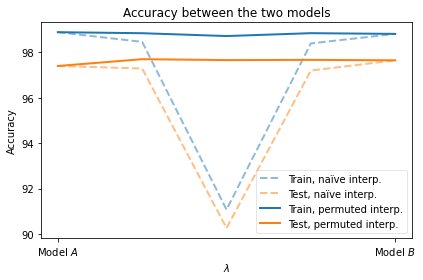

In [34]:
# First we do the basic linear interpolation plot
lambdas = torch.linspace(0, 1, steps=n_points)
fig = plot.plot_interp_metric("accuracy", lambdas, train_acc_naive, test_acc_naive, train_acc_perm, test_acc_perm)

# Geodesic MC in functional space

In [35]:
from mode_connectivity.geodesic_opt import optimise_for_geodesic, metric_path_length

In [36]:
# load in model state_dicts
model_file_path = 'mode_connectivity/model_files/' # use this path in colab

weights_a = torch.load(model_file_path + "mlp_mnist_model_a.pt", map_location=device)
weights_b = torch.load(model_file_path + "mlp_mnist_model_b.pt", map_location=device)
weights_pb = torch.load(model_file_path + "mlp_mnist_model_pb.pt", map_location=device)

In [37]:
train_kwargs = {"batch_size":128, 'num_workers': 0, 'pin_memory': False}
test_kwargs = {"batch_size":512, 'num_workers': 0, 'pin_memory': False}

train_loader, test_loader = data.get_data_loaders(
    dataset="mnist", train_kwargs=train_kwargs, test_kwargs=test_kwargs
)

### Optimise for geodesic

In [62]:
from super import SuperModel

N = 10

super_model = SuperModel(MLP, N, weights_a, weights_pb).to(device)

path_lengths, sq_euc_dists  = optimise_for_geodesic(
         super_model,
         train_loader,
         lr = 1e-1,
         verbose=1,
         num_epochs=2,
     )

Optimising geodesic ...
epoch 0 | path length 0.0031744035233660086 | sq euc dist 138.67666638990454
epoch 1 | path length 0.0029475467663922553 | sq euc dist 138.68196805453758


Text(0, 0.5, 'path action via (squared) euclid dist')

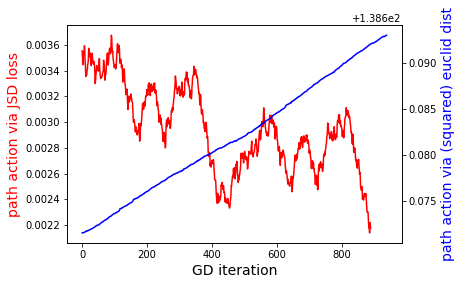

In [68]:
def rolling_mean(x, window):
    return np.convolve(x, np.ones(window), 'valid') / window

fig, ax = plt.subplots()

# CURRENTLY SET TO DO ROLLING MEAN
rolling_mean_length = rolling_mean(path_lengths, 50)

loss_type = 'JSD loss'

ax.plot(rolling_mean_length, color = 'red')
ax.set_xlabel('GD iteration', fontsize = 14)
ax.set_ylabel('path action via ' + loss_type, color = 'red', fontsize = 14)

ax2=ax.twinx()
ax2.plot(sq_euc_dists, color = 'blue')
ax2.set_ylabel('path action via (squared) euclid dist', color = 'blue', fontsize = 14)

In [99]:
from geodesic_opt import evaluate_geodesic

# path_lengths are per step, acc is per model
train_path_length, train_acc = evaluate_geodesic(super_model, train_loader, verbose=0)
test_path_length, test_acc = evaluate_geodesic(super_model, test_loader, verbose=0)

Calculating path length and acc over geodesic:
Calculating path length and acc over geodesic:
[0.00035396 0.00032585 0.00026236 0.00020912 0.00017839 0.00021244
 0.00028218 0.00036001 0.0003961 ] [99.031624 99.11825  99.1349   99.10492  99.07327  99.0716   99.06328
 99.04995  98.991646 98.86783 ]
[0.00042949 0.00037465 0.00029751 0.00024436 0.00022845 0.00027677
 0.00035211 0.00044461 0.00050173] [97.82399  97.91188  98.03768  98.027916 97.98885  97.94979  97.921646
 97.76769  97.57985  97.38454 ]


In [100]:
!cd mode_connectivity && git status

On branch super_model
Your branch is up to date with 'origin/super_model'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   geodesic_opt.py

no changes added to commit (use "git add" and/or "git commit -a")
